In [3]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

% matplotlib inline

# Question 1: Propensity score matching

## 1.1 A naive analysis
We start by importing the data and then split them into 2 subgroups: control and treated. We display some informations on the distributions and some plots.

*NOTE: we play dumb on purpose for this first "naive" analysis. A very succinct analysis of the number and distribution is given, without asking ourselves the typical questions that a data scientist should adress when given any dataset.*

In [4]:
#Display 2 dataframes from the same cell
from IPython.display import display

df = pd.read_csv('lalonde.csv')

#Create the 2 groups
treated = df.loc[df['treat'] == 1]
control = df.loc[df['treat'] == 0]

# display floats in dataframe with only 2 digits after comma
pd.options.display.float_format = '{:,.2f}'.format

#Informations on both distributions while dropping irrelevant columns
display(treated.drop(['id', 'treat', 'black', 'hispan', 'married', 'nodegree'], axis=1).describe())
display(control.drop(['id', 'treat', 'black', 'hispan', 'married', 'nodegree'], axis=1).describe())

,age,educ,re74,re75,re78
count,185.00,185.00,185.00,185.00,185.00
mean,25.82,10.35,"2,095.57","1,532.06","6,349.14"
std,7.16,2.01,"4,886.62","3,219.25","7,867.40"
min,17.00,4.00,0.00,0.00,0.00
25%,20.00,9.00,0.00,0.00,485.23
50%,25.00,11.00,0.00,0.00,"4,232.31"
75%,29.00,12.00,"1,291.47","1,817.28","9,643.00"
max,48.00,16.00,"35,040.07","25,142.24","60,307.93"


,age,educ,re74,re75,re78
count,429.00,429.00,429.00,429.00,429.00
mean,28.03,10.24,"5,619.24","2,466.48","6,984.17"
std,10.79,2.86,"6,788.75","3,292.00","7,294.16"
min,16.00,0.00,0.00,0.00,0.00
25%,19.00,9.00,0.00,0.00,220.18
50%,25.00,11.00,"2,547.05","1,086.73","4,975.51"
75%,35.00,12.00,"9,277.13","3,881.42","11,688.82"
max,55.00,18.00,"25,862.32","18,347.23","25,564.67"


From the figures computed, we see that the two groups do not have the same number of participants. We see that the average age of participants is 25.82 for treated group, and 28.03 for control group, which is slighty different but still rather similar. The mean of years studied is almost the same in the two groups. Regarding the incomes, we can see that on average, before treatment (re74 and re 75 entries) the salary of the treated group was lower than the average incomes of the control group. <br>
Finally, from the the incomes of 78 (re78), we see that after treatment, the difference of average salary is strongly reduced between the two groups. What is interesting to see is that the range of salary for control group is rather small : from 0 (no incomes-unemployed) to 25'564.67\$ whereas for the treated group, the range is way bigger and goes from 0 to 60'307.93\$. 

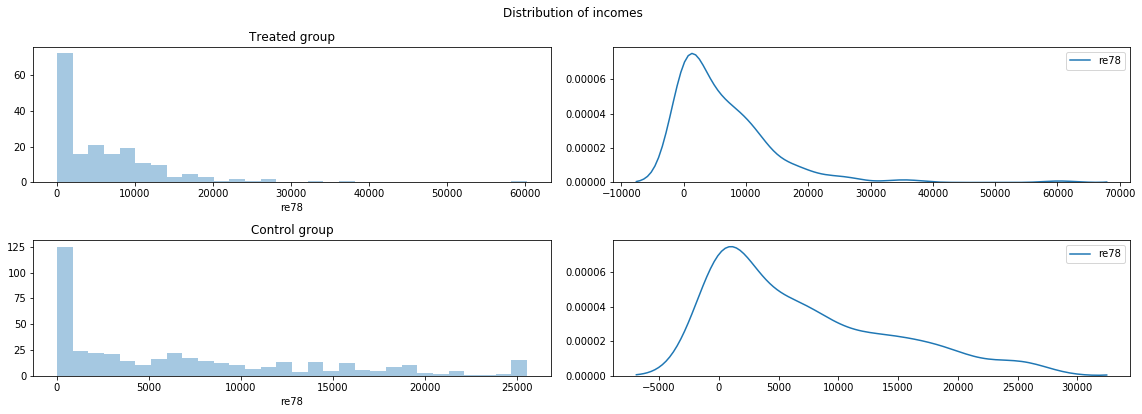

In [5]:
# Plots
fig, axes = plt.subplots(2,2, figsize=(16,6))
plt.suptitle('Distribution of incomes')
axes[0,0].set_title('Treated group');
sns.distplot(treated['re78'], kde=False, ax=axes[0,0], bins=30)
sns.kdeplot(treated['re78'], ax=axes[0,1])
axes[1,0].set_title('Control group')
sns.distplot(control['re78'], kde=False, ax=axes[1,0], bins=30)
sns.kdeplot(control['re78'], ax=axes[1,1])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

From a naive analysis we can see that the controled group seems to have a more spread distribution within its range, but that could be related to the higher number of samples. In comparison, the treated group has many subjects whose salary is in the range 0-15'000\$ and few subject with very high salaries. In both cases, the mean is on the right side of the median and we can therefore conclude that they are both positively skewed. 

## 1.2 A closer look at the data

### Distributions from the treated group

One should notice that we should analyse binary features (black, hispan, married, nodegree) differently than non-binary features (age, educ, re74, re75 and re78).
#### Non-Binary Features

In [6]:
def plot_distributions_nbinary(df, compare_col):
    '''Plot comparative graphs for selected features of both dataframes'''
    plt.figure(figsize=(16,12))
    #fig, axes = plt.subplots(len(compare_col), 2, figsize=(16,12))
    for i, col in enumerate(compare_col):
        # Violinplot to compare data
        ax = plt.subplot(3, 2, i+1)
        sns.violinplot(data=df, x=compare_col[i], y='treat', ax=ax, inner="quartile", palette='Set2', orient='h');
        ax.set_title('Feature: ' + compare_col[i])
    plt.tight_layout()

/Users/alexandre/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/alexandre/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


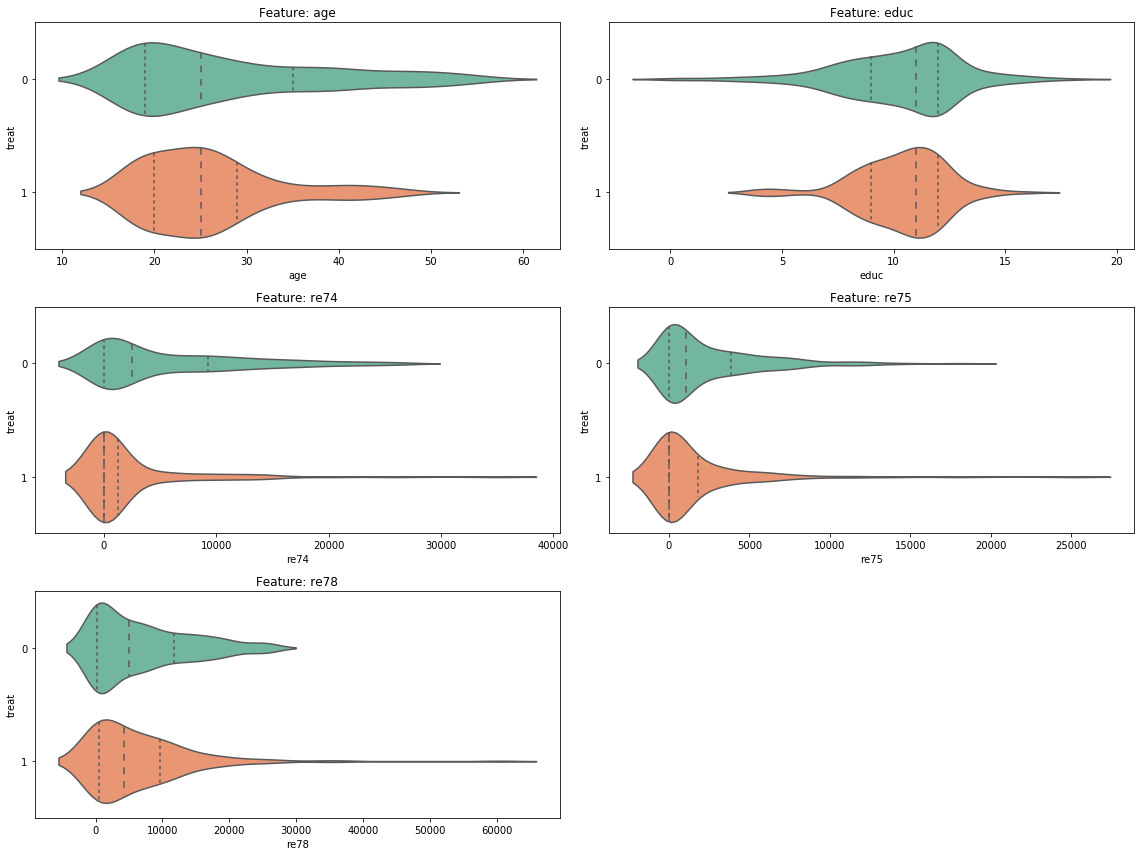

In [7]:
plot_distributions_nbinary(df, ['age', 'educ', 're74', 're75', 're78'])

We can observe some differences between the distributions. The control group seems to be younger, more spread (probably due to the higher number of samples), the revenues in 74, 75 and 78 are a bit higher, at least in mean than the treated group. Nevertheless, the education feature reveals a similar distribution for both groups.
These informations couldn't be seen with the naive analysis above. Now we can focus on the other (binary) features:

#### Binary Features

In [8]:
def plot_binary_proportions(df, columns, width = 0.3 ):
    fig, ax = plt.subplots(1, 1, figsize=(10,4))
    r = df.groupby('treat').sum()[columns]
    r = r.div(r.sum())
    ids_ = np.arange(len(columns))
    p1 = plt.bar(ids_, r.iloc[0], width, alpha=0.7, label='control')
    p2 = plt.bar(ids_+width, r.iloc[1], width, alpha=0.7, label='treated')
    
    plt.xlabel('Different classes')
    plt.ylabel('Ratio of people')
    plt.title('Repartition of subject along different categories')
    plt.xticks(ids_ + width / 2, tuple(columns))
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

In [9]:
df.head()

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
0,NSW1,1,37,11,1,0,1,1,0.00,0.00,"9,930.05"
1,NSW2,1,22,9,0,1,0,1,0.00,0.00,"3,595.89"
2,NSW3,1,30,12,1,0,0,0,0.00,0.00,"24,909.45"
3,NSW4,1,27,11,1,0,0,1,0.00,0.00,"7,506.15"
4,NSW5,1,33,8,1,0,0,1,0.00,0.00,289.79


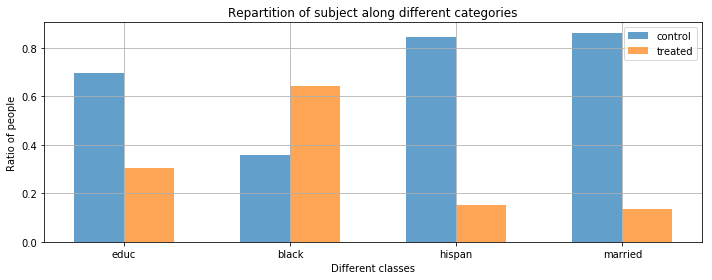

In [10]:
plot_binary_proportions(df, ['educ', 'black', 'hispan', 'married'])

By looking at the distribution of the "binary" features, we see that the racial distibution between the two groups is very different. In the treated group, there is more than 80% of black people and less than 10% of hispanic people, and we can guess that the rest would be white people. In the control group however, there is only 20% of black people and 15% of hispanic, meaning that we have a majority of white people in the control group. As for the other values, the treated group has approximately 20% of marreid people whereas in the control group there is approximately 50% of married subjects. Lastly, the proportion of subjects without a degree is higher in the treated group, approximately 70% against 60% in the control group. <br>
All those diffrences in proportion from the control group to the treated group raise the problem of population bias (systematic difference of population within the control group vs the treated group) between the two cohorts observed. This bias will skew the analysis as the comparison between the two cohort is not fair. For a fair comparison, it would be necessary to have similar amount of proportion with specific attributes between the two populations observed.

### 1.3 A propensity score model

We use **linear_model** from sklearn in order to define the propensity score for each sample. In order to apply our logistic regression we drop 2 columns for the input: **id** since it doen't contain relevant information and **treat** beacause it is our output.

In [11]:
from sklearn import linear_model

logistic = linear_model.LogisticRegression()
X = df.drop(['id','treat'], axis=1)
y = df['treat']
logistic.fit(X, y)
y_pred_proba = logistic.predict_proba(X)

In [14]:
df['score'] = y_pred_proba[:, 1]
display(df[182:188])

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,score
182,NSW183,1,35,9,1,0,1,1,"13,602.43","13,830.64","12,803.97",0.43
183,NSW184,1,35,8,1,0,1,1,"13,732.07","17,976.15","3,786.63",0.44
184,NSW185,1,33,11,1,0,1,1,"14,660.71","25,142.24","4,181.94",0.44
185,PSID1,0,30,12,0,0,1,0,"20,166.73","18,347.23","25,564.67",0.07
186,PSID2,0,26,12,0,0,1,0,"25,862.32","17,806.55","25,564.67",0.05
187,PSID3,0,25,16,0,0,1,0,"25,862.32","15,316.21","25,564.67",0.03


We then have a final dataframe with the propensity score for each row.

### 1.4 Balancing the dataset via matching

In [15]:
from scipy.optimize import linear_sum_assignment

#Create the 2 groups
treated = df.loc[df['treat'] == 1]
control = df.loc[df['treat'] == 0]

# Create a matrix with distances between every subjects
dist = np.zeros([len(treated['score']), len(control['score'])])
for i, t in enumerate(treated['score']):
    for j, c in enumerate(control['score']):
        dist[i, j] = abs(t-c)

# We use scipy to check that the sum of absolute propensity-score differences 
# between the two matched subjects is minimized.
row_ind, col_ind = linear_sum_assignment(dist)
matched_df = pd.concat([treated, control.iloc[col_ind]])

# The first 185 subjects match to the last 185 subjects of this dataframe
matched_df.iloc[[1, 1+185]]

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,score
1,NSW2,1,22,9,0,1,0,1,0.00,0.00,"3,595.89",0.15
425,PSID241,0,18,12,0,1,0,0,0.00,630.19,"4,843.99",0.15


In [16]:
# We can check that we have unique matching values (2x185). 
matched_df['id'].nunique()

370

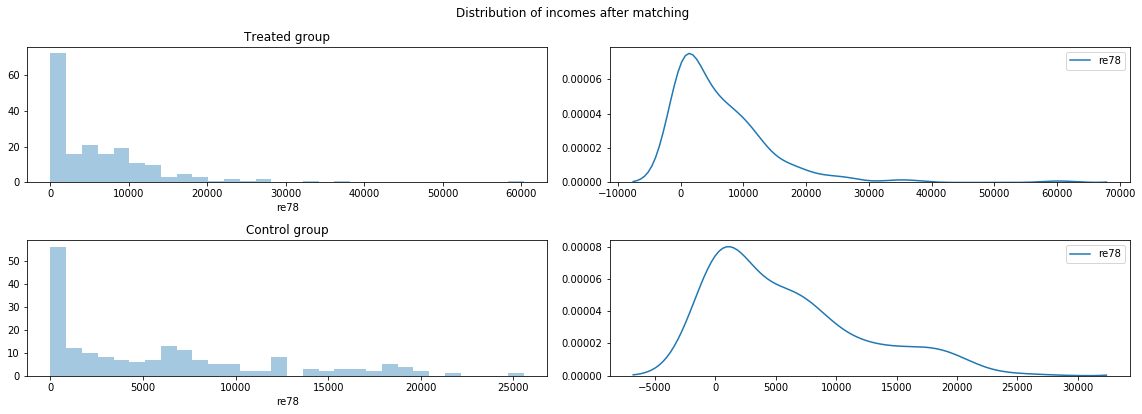

In [20]:
# Plots
fig, axes = plt.subplots(2,2, figsize=(16,6))
plt.suptitle('Distribution of incomes after matching')
axes[0,0].set_title('Treated group');
sns.distplot(matched_df.iloc[0:185]['re78'], kde=False, ax=axes[0,0], bins=30)
sns.kdeplot(matched_df.iloc[0:185]['re78'], ax=axes[0,1])
axes[1,0].set_title('Control group')
sns.distplot(matched_df.iloc[185:370]['re78'], kde=False, ax=axes[1,0], bins=30)
sns.kdeplot(matched_df.iloc[185:370]['re78'], ax=axes[1,1])
fig.tight_layout(rect=[0, 0.03, 1, 0.95])

In [21]:
#Informations on both distributions while dropping irrelevant columns
display(matched_df.iloc[0:185].drop(['id', 'treat', 'black', 'hispan', 'married', 'nodegree'], axis=1).describe())
display(matched_df.iloc[185:370].drop(['id', 'treat', 'black', 'hispan', 'married', 'nodegree'], axis=1).describe())

,age,educ,re74,re75,re78,score
count,185.00,185.00,185.00,185.00,185.00,185.00
mean,25.82,10.35,"2,095.57","1,532.06","6,349.14",0.56
std,7.16,2.01,"4,886.62","3,219.25","7,867.40",0.21
min,17.00,4.00,0.00,0.00,0.00,0.04
25%,20.00,9.00,0.00,0.00,485.23,0.45
50%,25.00,11.00,0.00,0.00,"4,232.31",0.65
75%,29.00,12.00,"1,291.47","1,817.28","9,643.00",0.70
max,48.00,16.00,"35,040.07","25,142.24","60,307.93",0.89


,age,educ,re74,re75,re78,score
count,185.00,185.00,185.00,185.00,185.00,185.00
mean,23.17,9.86,"2,268.39","1,670.14","5,828.58",0.38
std,9.34,2.78,"4,266.74","2,734.93","6,094.31",0.23
min,16.00,0.00,0.00,0.00,0.00,0.04
25%,17.00,8.00,0.00,0.00,237.91,0.18
50%,19.00,10.00,336.99,470.85,"4,112.51",0.24
75%,24.00,12.00,"2,217.89","1,976.52","8,957.98",0.65
max,55.00,17.00,"21,918.32","13,776.53","25,564.67",0.79


Now that we have a better dataset, we can see that revenues re78 of the treated group are a bit higher that the control group. Indeed the mean is around 500$ more than the control group and all of the quantiles are also higher.
The treatement might have an effect of the incomes.

/Users/alexandre/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/alexandre/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


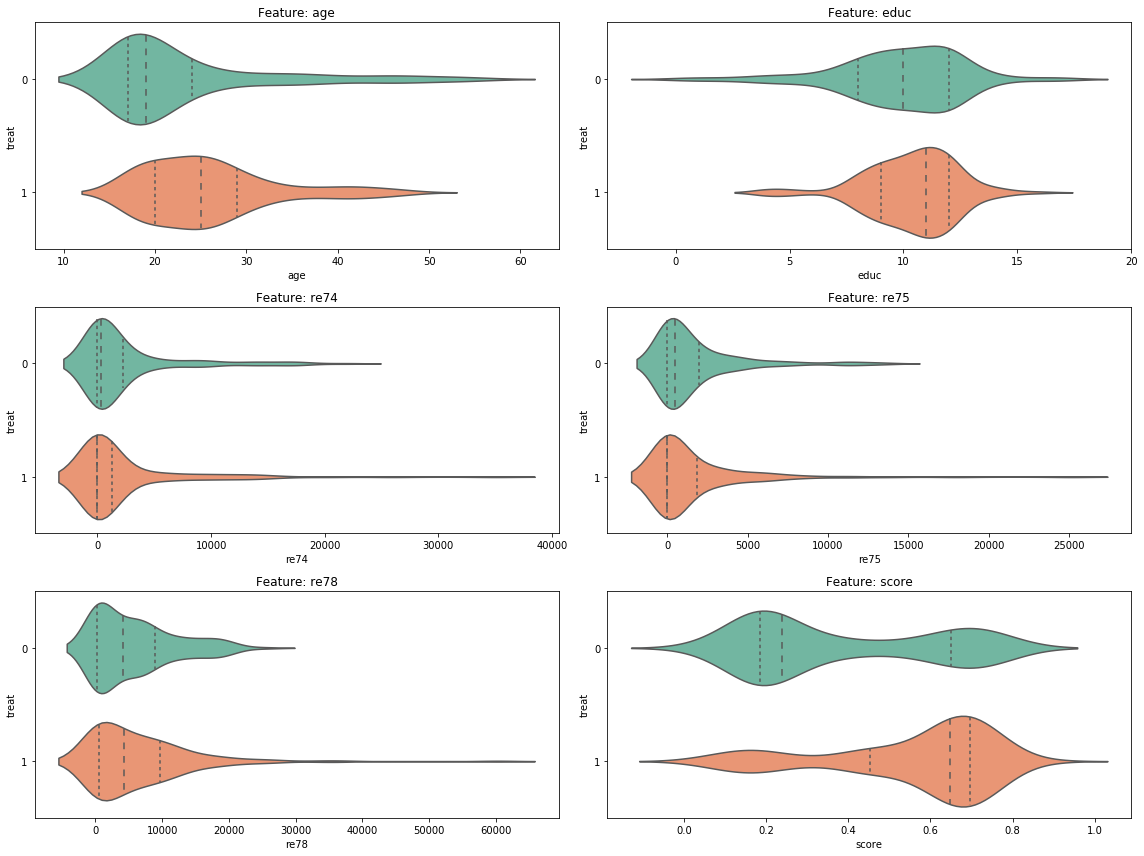

In [22]:
plot_distributions_nbinary(matched_df, ['age', 'educ', 're74', 're75', 're78', 'score'])

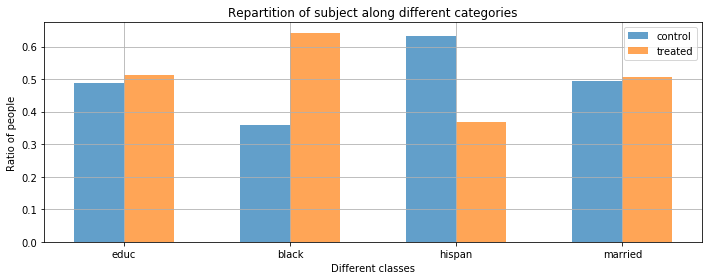

In [23]:
plot_binary_proportions(matched_df, ['educ', 'black', 'hispan', 'married'])

# <font color="red">TODO: Blabla</font>


### 1.5 Balancing the groups further

No, we aren't fully satisfied since there are still differences in distributions between the races, some outliers in the treated group which biased a bit our analysis (>60k in re78). 
Nevertheless it becomes harder to process better population similarities with matching. One idea could be to define an error threshold which would allow us to discard some treated inputs and only keep the most similar subjects from each cohort. But with this, we would reduce our dataset which is already small.

In [18]:
feat_sected = ['age', 'educ', 'black', 'hispan', 'married', 'nodegree'] # Features used to compare people

df_treated = matched_df.iloc[:185].reset_index()[feat_sected]
df_control = matched_df.iloc[185:].reset_index()[feat_sected]

res = (df_treated-df_control)/(df_control + 1e-5)

In [19]:
ids_match_new = np.nonzero(np.sum(np.abs(res) > 0.5, axis=1) == 0)[0]
ids_match_new = np.array([ids_match_new, ids_match_new+185]).flatten()

/Users/alexandre/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/alexandre/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


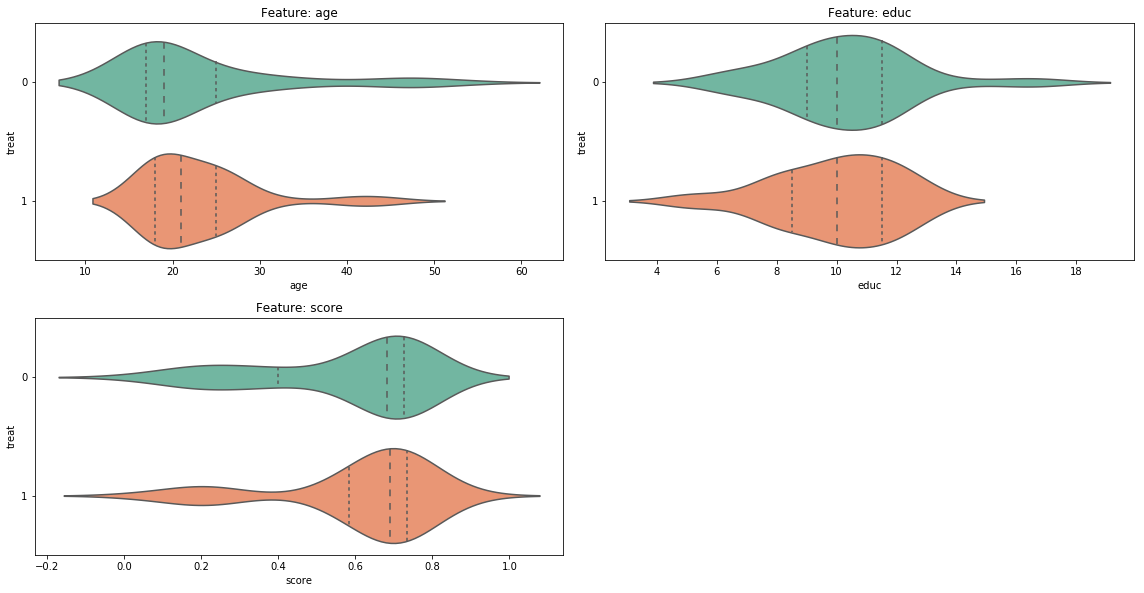

In [20]:
matched_new_df = matched_df.iloc[ids_match_new]
plot_distributions_nbinary(matched_new_df, ['age', 'educ', 'score'])

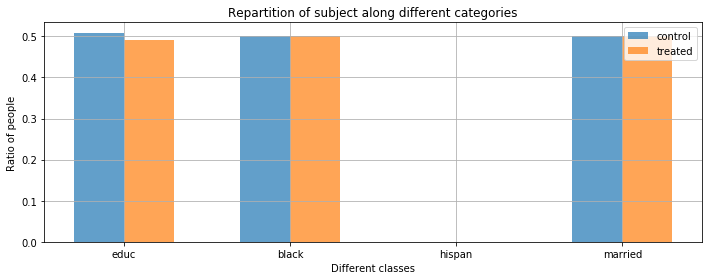

In [21]:
plot_binary_proportions(matched_new_df, ['educ', 'black', 'hispan', 'married'])

# <font color="red">TODO: Blabla + Code</font>

### 1.6 A less naive analysis

/Users/alexandre/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:598: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  kde_data = remove_na(group_data)
/Users/alexandre/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:826: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  violin_data = remove_na(group_data)


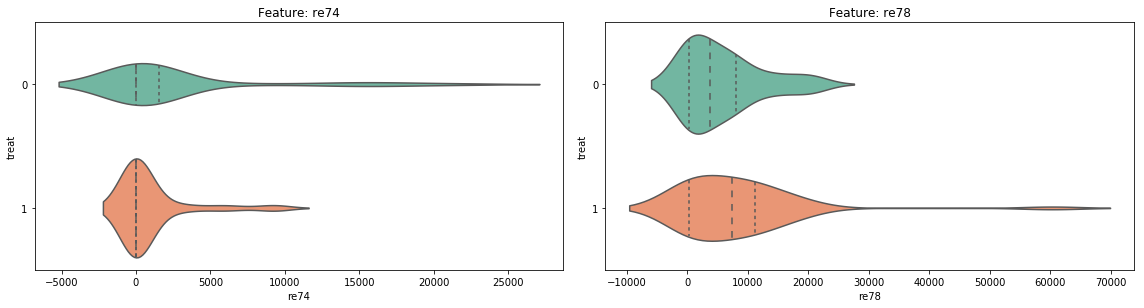

In [22]:
plot_distributions_nbinary(matched_new_df, ['re74', 're78'])

# Question 2: Applied ML

## 2.1 Data loading and features extraction

First we will download the dataset as explained and take a look at the dataset. It is a collection of approximately 20,000 newsgroup documents, partitioned across 20 different newsgroups. For more information go to [this website](http://qwone.com/~jason/20Newsgroups/). The data is composed of multiple fields.

* `data`: is the actual text and description of the news.
* `target`: is the label (as integers) of the news that are part of the 20 categories present in `target_names` (displayed later).
* `filename`: is the location of the file.
* `descritpion`: is the title of the dataset, here : "the 20 newsgroups by date dataset".
* `DESCR` is empty
* `target_names`: is the list of target we are trying to match (news categories linked to `target`).

In [ ]:
newsgroups = fetch_20newsgroups(subset='all')

In [ ]:
list(newsgroups.keys())

Note that some labels are actually sub categroies. For example `politics.guns` and `politics.mideast` are both subcategories of `talk`. We can expect it will be more difficult to discriminate and classify news that are part of the same category.

In [ ]:
newsgroups.target_names

We can now create our TF-IDF matrix. The matrix will be sparse and huge since we are not removing any words or limiting the number of features. Here for example the size of vocabulary (features) is 173762.

In [ ]:
tfidf = TfidfVectorizer()
x_tfidf = tfidf.fit_transform(newsgroups.data) 
len(tfidf.vocabulary_)

As asked we will split our data in 3 different sets: `train` (80%), `validation` (10%) and `test` (10%). We will assert our results on the validation set before testing it on the test set. Note that we fixed the seed to 0 for reproducibility purposes.

In [ ]:
ratio_train = 0.8
ratio_validation = 0.1

np.random.seed(0)
id_ = np.random.permutation(np.arange(x_tfidf.shape[0]))
id_train = id_[:np.ceil(x_tfidf.shape[0]*ratio_train).astype(int)]
id_validation = id_[np.floor(x_tfidf.shape[0]*ratio_train).astype(int):
                    np.ceil(x_tfidf.shape[0]*(ratio_train+ratio_validation)).astype(int)]
id_test = id_[np.floor(x_tfidf.shape[0]*(ratio_train+ratio_validation)).astype(int):]

Now that we randomly split our data ids we can create our features sets and labels for classification.

In [ ]:
x_train = x_tfidf[id_train]
x_validation = x_tfidf[id_validation]
x_test = x_tfidf[id_test]

y_train = newsgroups.target[id_train]
y_validation = newsgroups.target[id_validation]
y_test = newsgroups.target[id_test]

## 2.2 Classification using Random Forest

### 2.2.1 Train and Validation set

We decided to go from 0 to around 200 features for both `max_depth` and `n_estimators`. Note that we choosed a logaritmic scale for features numbers since there are no resons to compare values such as for example `max_depth`=63 to `max_depth`=64 since they will give similar results.

In [ ]:
span_depth = np.ceil(np.logspace(0, 2.3, 15)).astype(int)
span_estimators = np.ceil(np.logspace(0, 2.3, 15)).astype(int)

In [ ]:
score = np.zeros((span_depth.shape[0], span_estimators.shape[0]))

for i, n_depth in enumerate(span_depth):
    for j, n_estimator in enumerate(span_estimators):
        clf = RandomForestClassifier(max_depth=n_depth, n_estimators=n_estimator, random_state=0, n_jobs=-1)
        clf.fit(x_train, y_train)
        y_pred = clf.predict(x_validation)
        score[i, j] = accuracy_score(y_pred, y_validation)
    print('Step {}/{} - Best accuracy max_depth={} is {:.4f}'.format(
        i+1, len(span_depth), n_depth, np.max(score[i])))

Since the grid search takes some time to run we saved the results to save time for next runs. Of course you can run the code from scratch at any time to test the results.

In [ ]:
np.save('score_random_forest.npy', 
        {'max_depth': span_depth, 'n_estimators': span_estimators, 'score': score})

In [ ]:
data = np.load('score_random_forest.npy')[()]

We can take a look at the accuracies and we observe that the larger the parameters `n_estimators` and `max_depth` are, the better the accuracy is. However we can also observe that we are reaching some limit. It seems that the algorithm is reaching a plateau around 86%.

In [ ]:
df_score = pd.DataFrame(data['score'])
df_score.columns = [str(num) for num in data['n_estimators']]
df_score.index = [str(num) for num in data['max_depth']]

plt.figure(figsize=(10, 8))
ax = sns.heatmap(df_score, annot=True, fmt=".2f", cmap='RdYlGn')
ax.set_xlabel('n_estimators'); ax.set_ylabel('max_depth');
ax.set_title('Accuracy score over "Max Depth" and "N Estimators"')

Here we can even more clearly see that we reached a plateau. There is only 4% augmentation in accuray for a difference of 169 in # of Estimators. As a consequence, we choosed to not try with higher values since they will not represent a significative improvement in accuracy.

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df_score.index, df_score.iloc[-1], label='max_d=200')
plt.plot(df_score.index, df_score.iloc[-3], label='max_d=94')
plt.plot(df_score.index, df_score.iloc[-6], label='max_d=31')
plt.xlabel('# Estimators'); plt.ylabel('Accuracy in %'); plt.grid(); 
plt.title('Accuracy on validation set as a funtion of MaxDepth and #Estimators'); plt.legend()

### 2.2.2 Results on Test set

We used the values we best score on validation set e.i. (Max Depth, # Estimators) = (200, 200). We can see that the result on the test set is similar to the one on the validation set with around 86% in accuracy. 

In [ ]:
clf = RandomForestClassifier(max_depth=200, n_estimators=200, random_state=0)
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
print('Accuracy on train set is {:.4f}'.format(accuracy_score(y_pred, y_test)))

To look more carefuly at the results we can compute the confusion matrix. Note that, by default, the matrix is not normalized and it is difficult to look at coherence of the results. We choosed to normalize it with 

$$\text{precision}_j = \frac{\text{tp}_j}{\text{tp}_j + \sum_{i \neq j} \text{fp}_i} $$

where $\text{tp}_j$ is the amount of true positive and $\text{fp}_i$ are the number of false positive for each class $j$. Note that we did not consider recall in this case.

In [ ]:
cm = confusion_matrix(y_pred, y_test)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

In [ ]:
df_conf = pd.DataFrame(cm)
df_conf.columns = newsgroups.target_names
df_conf.index = newsgroups.target_names

We can see that most classes are performing well with values close to 1. However we can see that some classes such as `soc.religion.christian` only have around 0.7 precision. It is interesting to notice that most of the fp are acually part of `talk.religion.misc` and fewer are `alt.atheism`. Those two topics are indeed related to the first one and we can conclude classification is harder. It is also interesting to notice that `misc.forsale` have fp spread around other classes such as `sci.electronics`, `comp.sys.mac.hardware`, or even `comp.graphics`. Thoses make also sense since this category (forsale) can include a lot of electronic devices and miscellaneous objects.

In [ ]:
plt.figure(figsize=(14, 10))
ax = sns.heatmap(df_conf, annot=True, fmt=".2f", cmap='RdYlGn')

### 2.2.3 Feature Importances
Let's now look at the features more carefuly. If we plot the repartition of the feature importances we can see that there are actually a lot of features that have little importance in classification (close to 0). Moreover there are only around 20 feature that are above 0.002. Note that the y scale is logaritmic. 

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(clf.feature_importances_, bins=50)
plt.yscale('log', nonposy='clip')
plt.xlabel('Feature importance'); plt.ylabel('#Features');
plt.grid(); plt.title('Repartition of feature importance')

As explained before it seems that a small set of top feature have huge impact on clssification. Let's display the 50 with highest importance and therefore look at the relevant words use for classification. It is interessting to notice that some words are actually part of the categories (labels) names. For example "baseball" with `rec.sport.baseball`, "gun" with `talk.politics.gun` or "sale" with `forsale`. However it is wierd to have some unrelevant words such as "are", "you", "for", "the" or even "it" that are often considered as stop words.

In [ ]:
n_features = 50
id_max = np.argsort(clf.feature_importances_)[-n_features:]
np.array(tfidf.get_feature_names())[id_max]